In [1]:
# load some libraries
import sys
import os
sys.path.insert(1, '..')
os.chdir('..')

import darts
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.darts_processing import *

# Glucose plots

In [2]:
# plots of uninterpolated glucose data for each patient
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', use_covs=True, use_static_covs=True)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Height: REAL_VALUED (STATIC_INPUT)
		Weight: REAL_VALUED (STATIC_INPUT)
		Gender: REAL_VALUED (STATIC_INPUT)
		Race: REAL_VALUED (STATIC_INPUT)
		EduLevel: REAL_VALUED (STATIC_INPUT)
		AnnualInc: REAL_VALUED (STATIC_INPUT)
		MaritalStatus: REAL_VALUED (STATIC_INPUT)
		DaysWkEx: REAL_VALUED (STATIC_INPUT)
		DaysWkDrinkAlc: REAL_VALUED (STATIC_INPUT)
		DaysMonBingeAlc: REAL_VALUED (STATIC_INPUT)
		T1DDiagAge: REAL_VALUED (STATIC_INPUT)
		NumHospDKA: REAL_VALUED (STATIC_INPUT)
		NumSHSinceT1DDiag: REAL_VALUED (STATIC_INPUT)
		InsDeliveryMethod: REAL_VALUED (STATIC_INPUT)
		UnitsInsTotal: REAL_VALUED (STATIC_INPUT)
		NumMeterCheckDay: REAL_VALUED (STATIC_INPUT)
		Aspir

In [3]:
# get ids from the data
ids = []
for i in range(len(series['train']['target'])):
    ids.append(series['train']['target'][i].static_covariates['id'][0])
# make a table of ids and how many of each id there are
ids_table = {id: 0 for id in ids}
for id in ids:
    ids_table[id] += 1
# select 5 ids with most number of components
ids = [id for id in ids_table if ids_table[id] > 5]
# extract glucose data for each id
id_series = {id: [] for id in ids}
for i in range(len(series['train']['target'])):
    for id in ids:
        if np.isclose(series['train']['target'][i].static_covariates['id'][0], id):
            id_series[id].append(series['train']['target'][i])
# inverse scale glucose data
for id in ids:
    id_series[id] = scalers['target'].inverse_transform(id_series[id])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


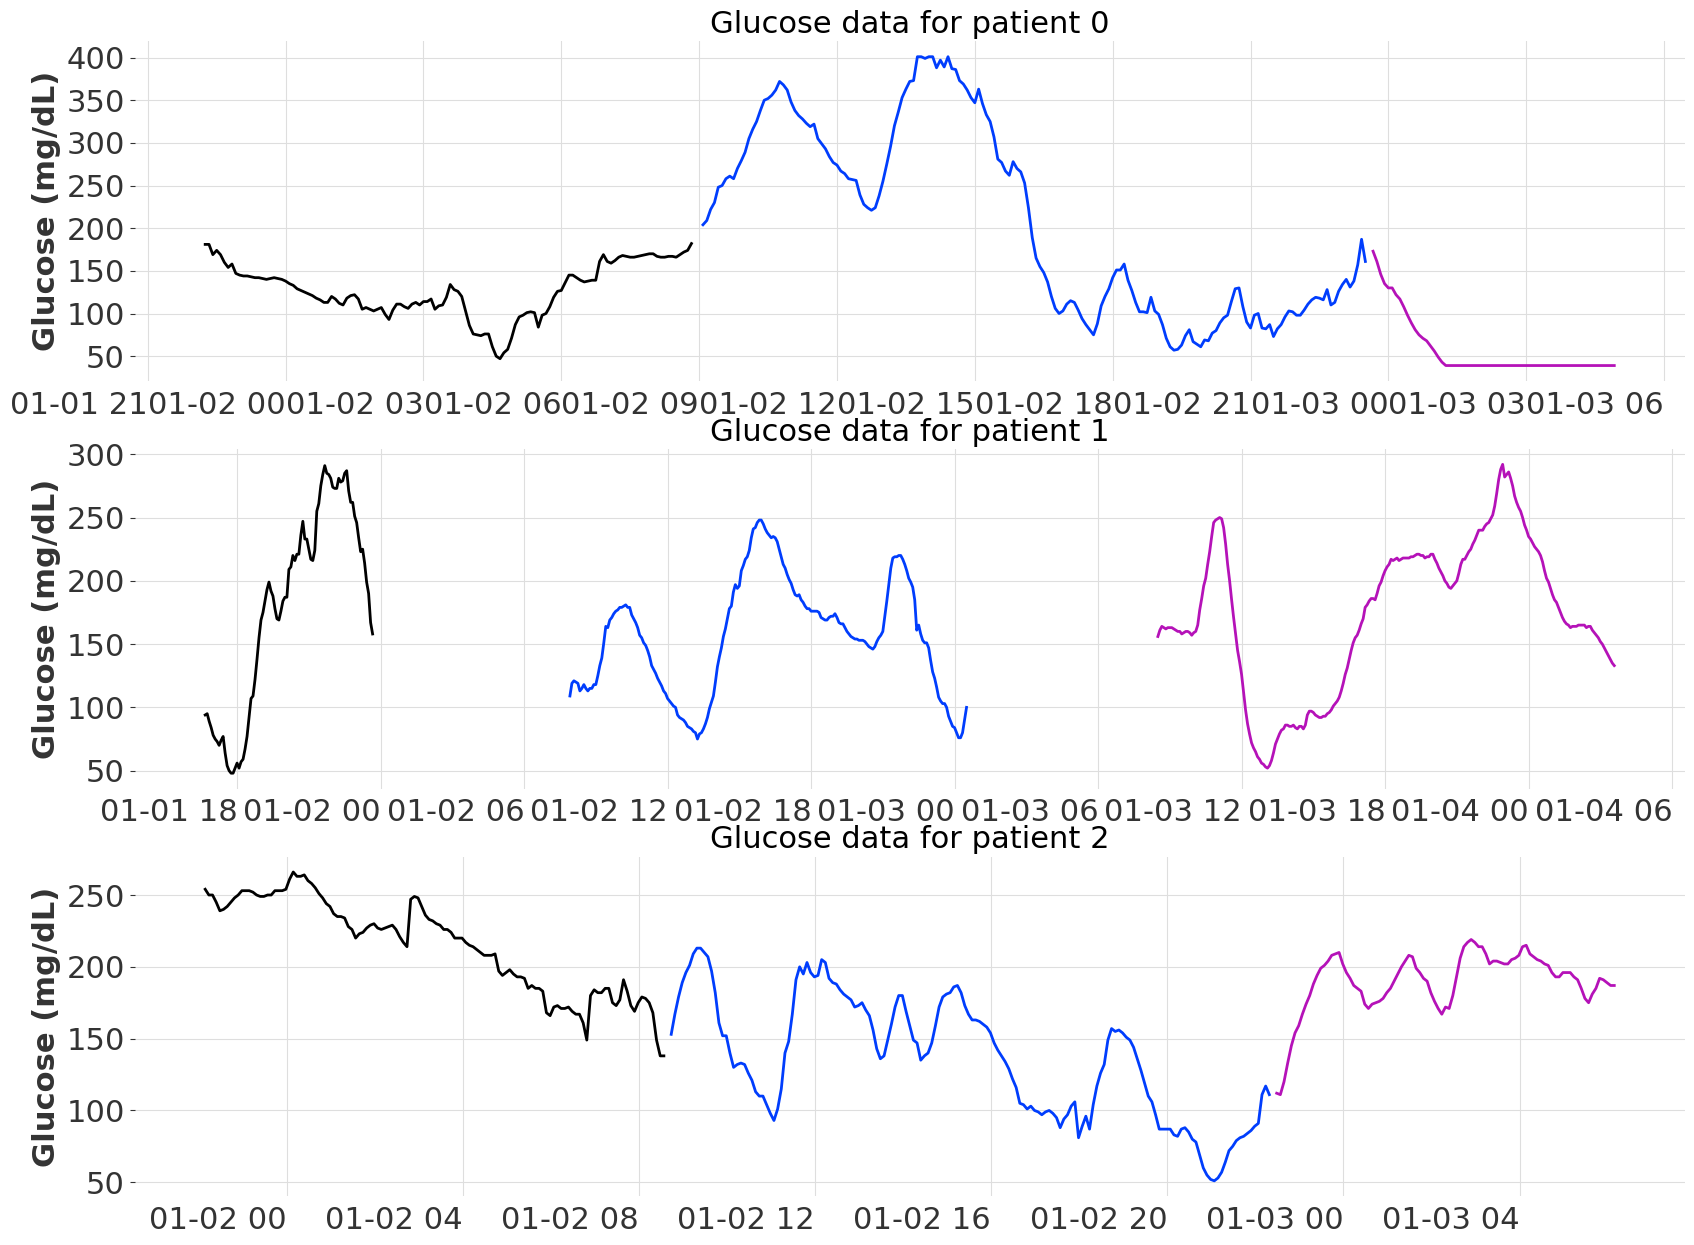

In [4]:
# plot glucose data for each id
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, id in enumerate(ids[:3]):
    for j in range(len(id_series[id][:3])):
        id_series[id][j].plot(ax=axs[i])
    # axs[i].get_legend().remove()
    axs[i].set_ylabel('Glucose (mg/dL)')
    axs[i].set_xlabel('')
    axs[i].set_title(f'Glucose data for patient {i}')
    axs[i].tick_params(axis='x', rotation=0)
    if axs[i].get_legend() is not None:
        axs[i].get_legend().remove()
    # increase font size
    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)
# save as pdf
plt.savefig('presentation/plots/glucose_data.pdf', bbox_inches='tight')

# Split and interpolation example plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


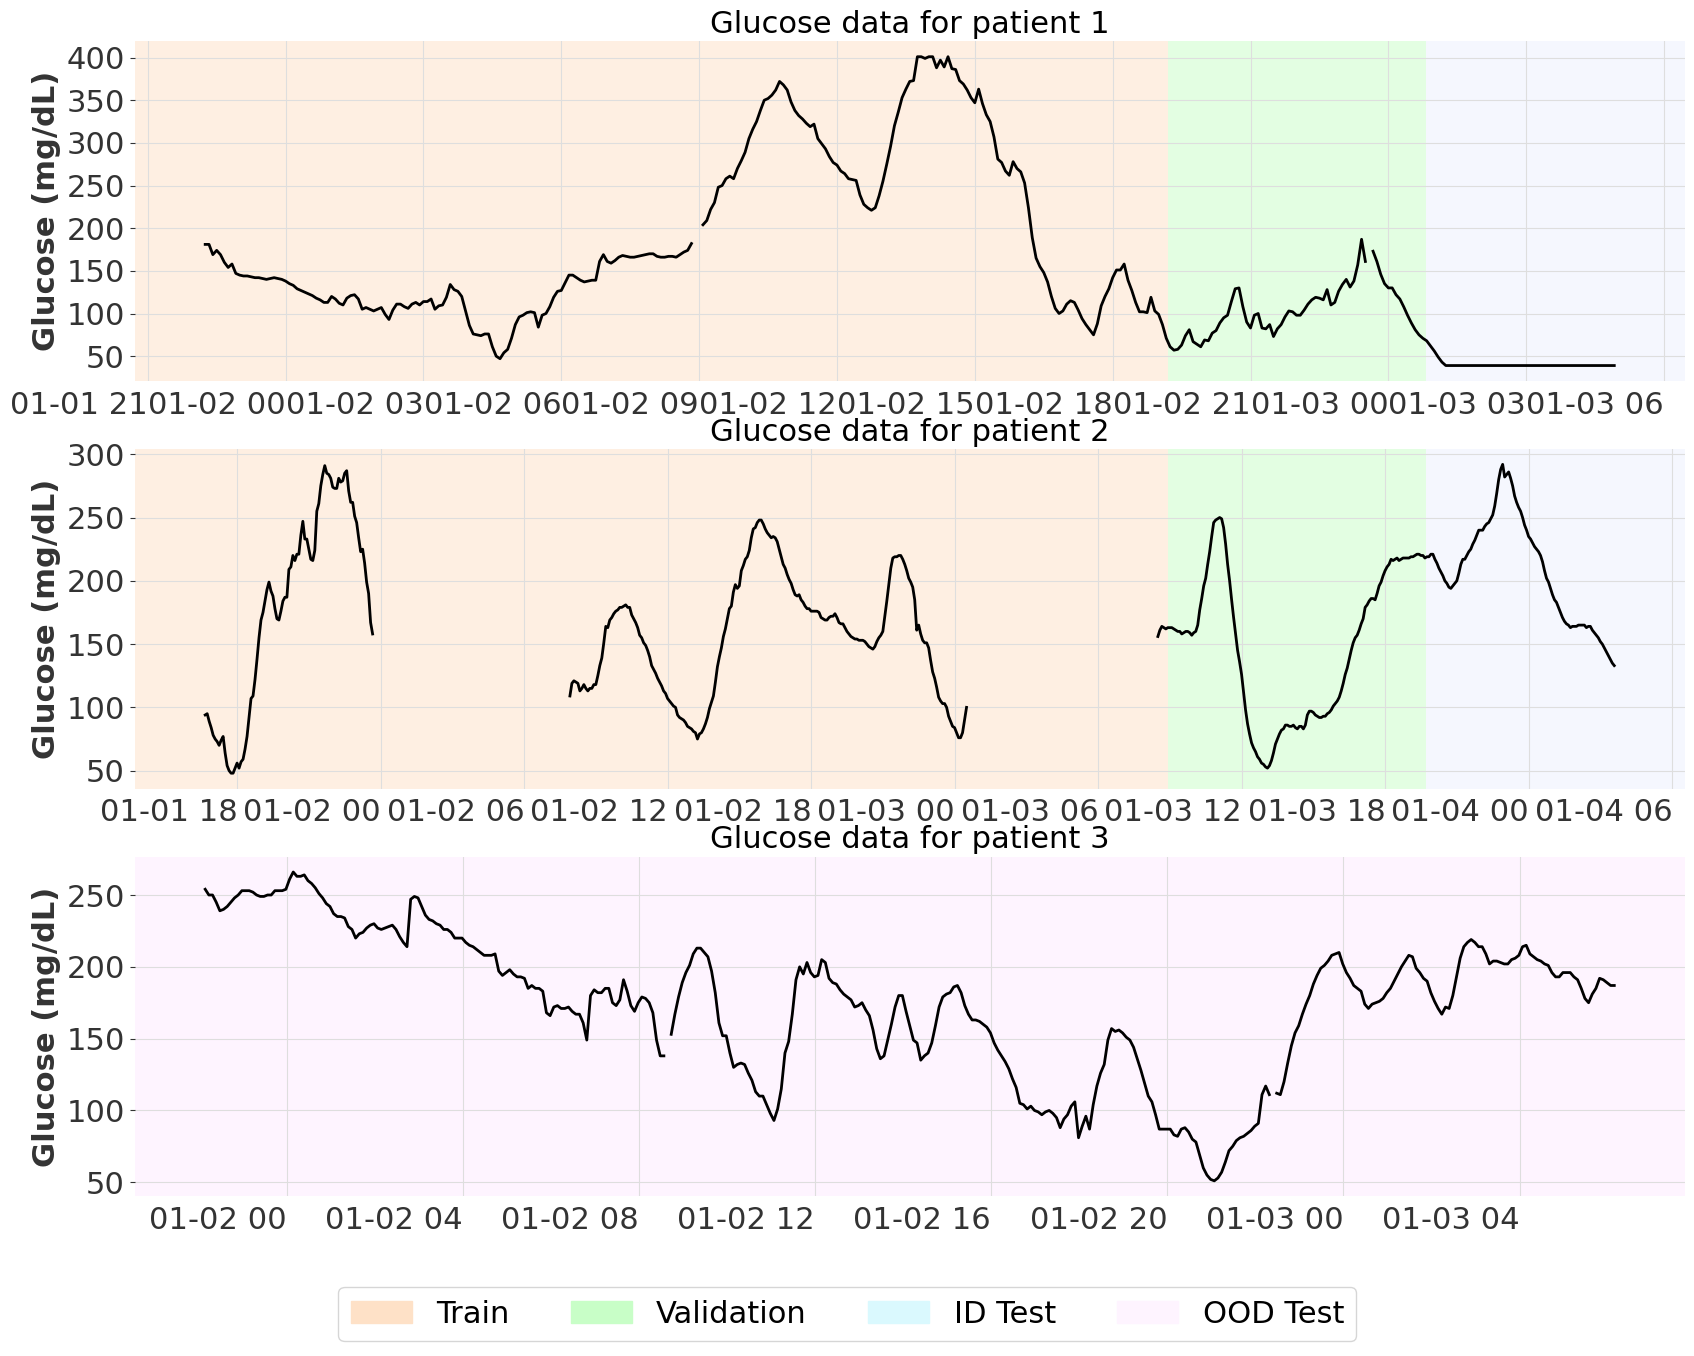

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Define the colors for the rectangles
colors = ['#FEE1C7', '#C8FEC7', '#DAF9FE', '#FEF4FF']
labels = ['Train', 'Validation', 'ID Test', 'OOD Test']

# plot glucose data for each id
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, id in enumerate(ids[:3]):
    for j in range(len(id_series[id][:3])):
        id_series[id][j].plot(ax=axs[i], color='black')  # Set the line color to black

    if i < len(ids[:3]) - 1:  # Only create rectangles for the first two plots
        y_min, y_max = axs[i].get_ylim()
        x_min, x_max = axs[i].get_xlim()
        total_width = x_max - x_min
        first_width = total_width * 2/3
        second_width = (total_width - first_width) / 2

        for k, color in enumerate(colors):
            if k == 0:
                width = first_width
            else:
                width = second_width
            rect = Rectangle((x_min + sum(width for width in [first_width, second_width][:k]), y_min),
                             width, y_max - y_min, facecolor=color, alpha=0.5)
            axs[i].add_patch(rect)
    else:  # Set the background color of the last plot to #D6EDFE
        axs[i].set_facecolor('#FEF4FF')

    axs[i].set_ylabel('Glucose (mg/dL)')
    axs[i].set_xlabel('')
    axs[i].set_title(f'Glucose data for patient {i+1}')
    axs[i].tick_params(axis='x', rotation=0)
    if axs[i].get_legend() is not None:
        axs[i].get_legend().remove()
    # increase font size
    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)

# Create a custom legend for the colors
legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor=color, label=label)
                   for color, label in zip(colors, labels)]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(colors), fontsize=22, frameon=True)

# save as pdf with transparent background
plt.savefig('presentation/plots/glucose_data_split_plot.pdf', bbox_inches='tight', transparent=False)


# Example plots of other Timeseries

In [6]:
# load electrcity data 
from darts.datasets import TemperatureDataset
from darts.datasets import AirPassengersDataset
from darts.datasets import HeartRateDataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


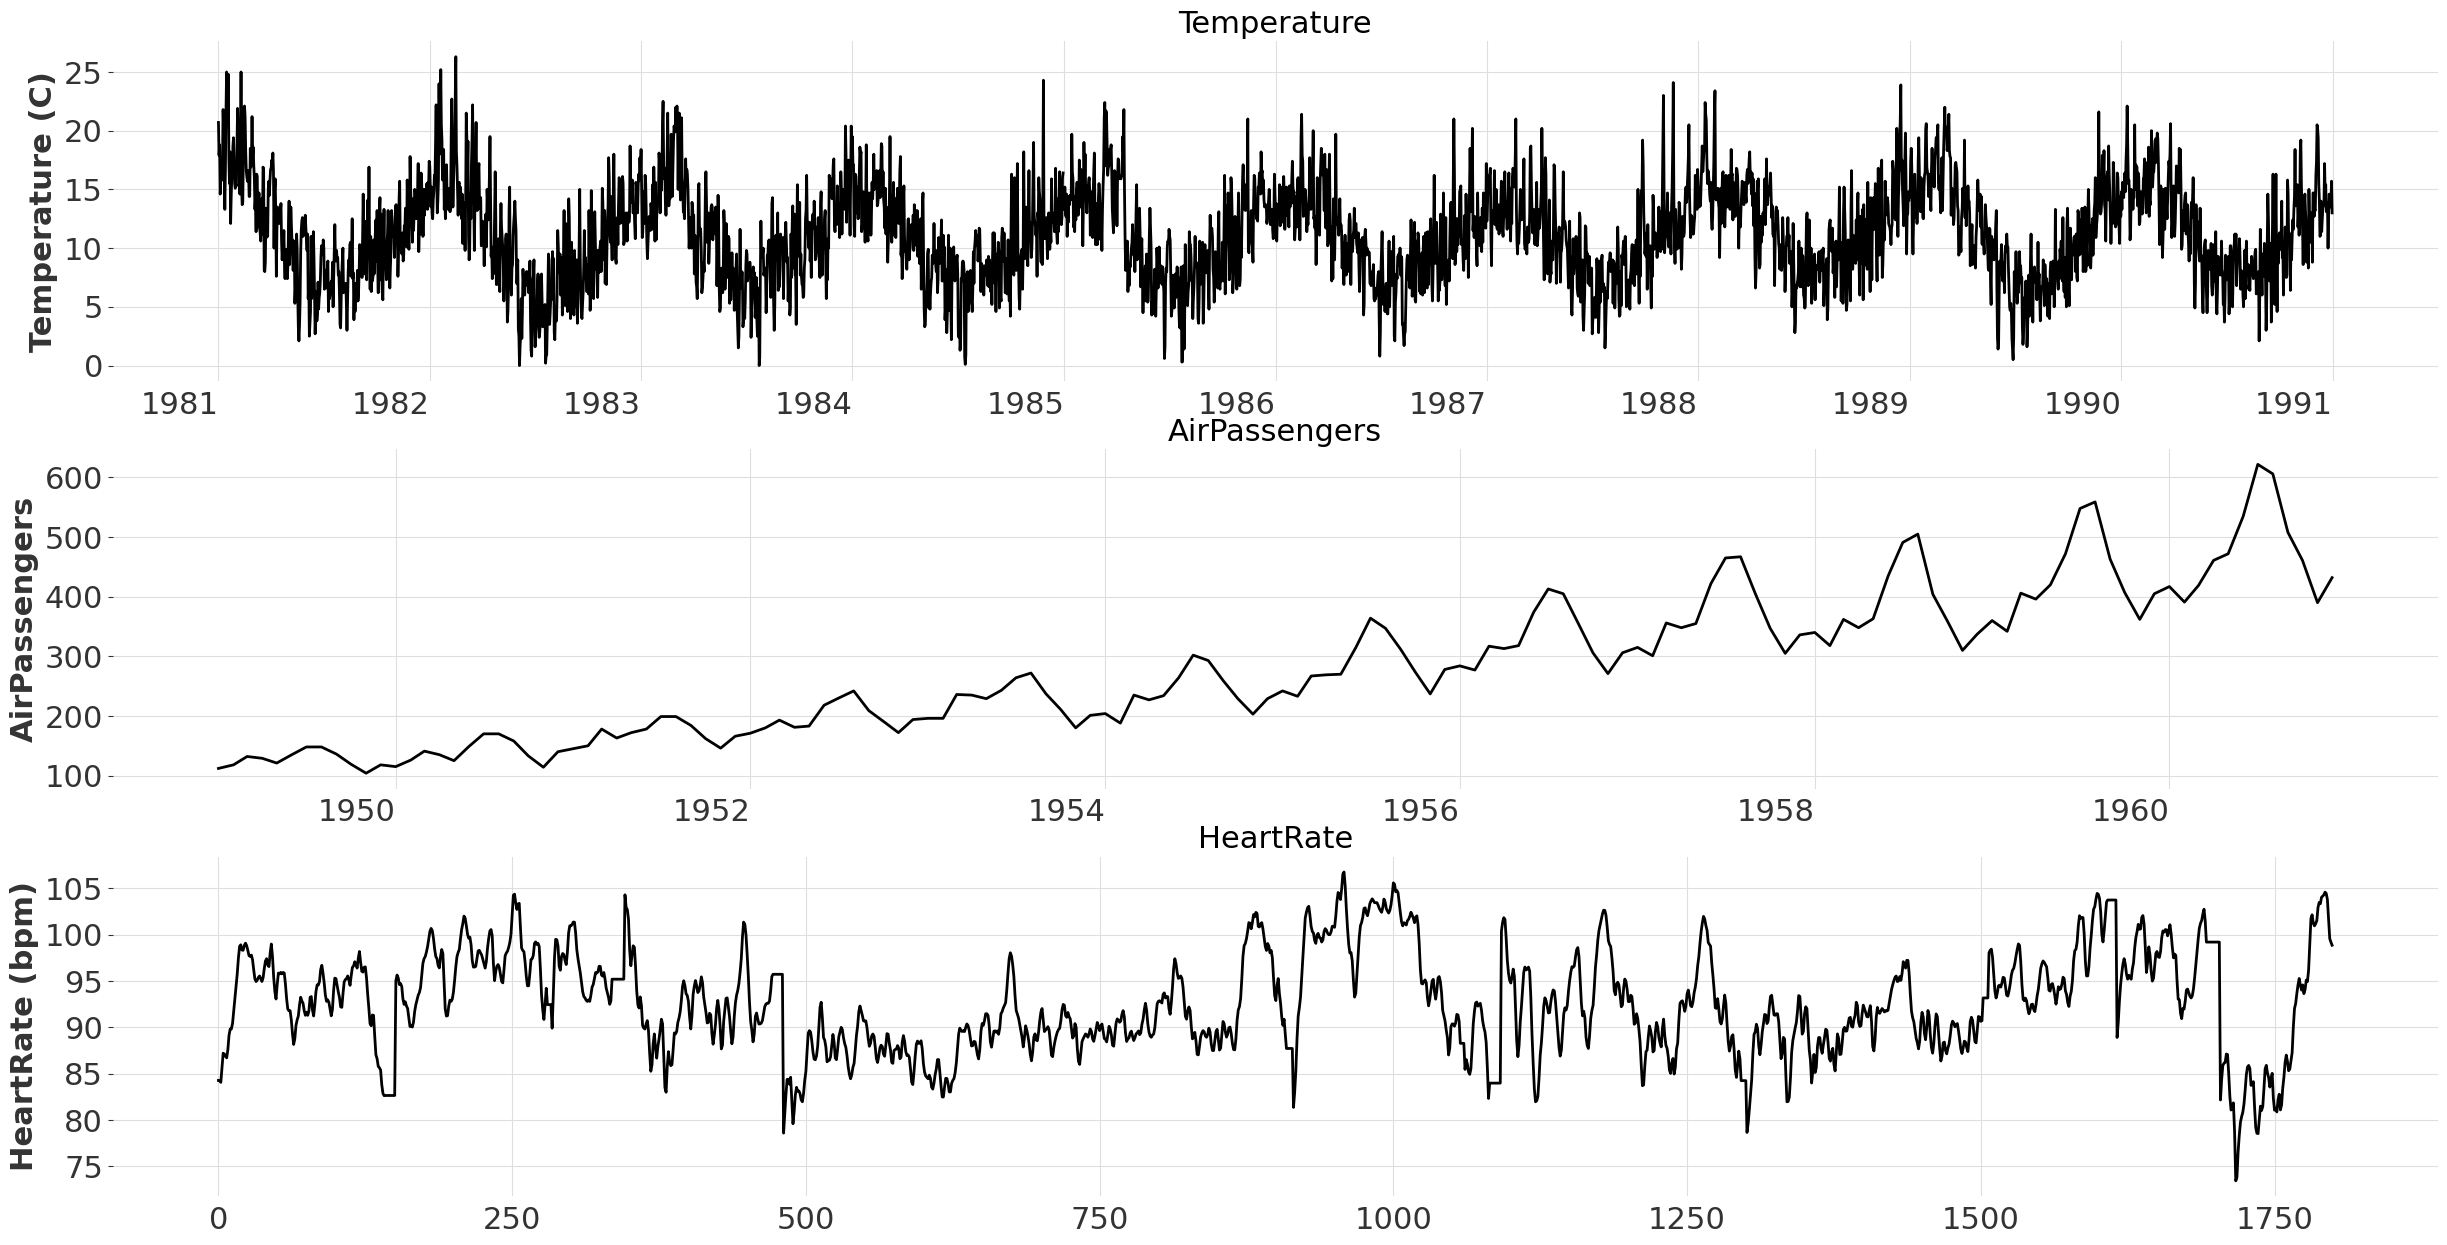

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(30, 15))
dataset_names = ['Temperature', 'AirPassengers', 'HeartRate']
yaxis = ['Temperature (C)', 'AirPassengers', 'HeartRate (bpm)']
for i, dataset in enumerate([TemperatureDataset(), AirPassengersDataset(), HeartRateDataset()]):
    dataset.load().plot(ax=axs[i])
    axs[i].set_ylabel(f'{yaxis[i]}')
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='x', rotation=0)
    axs[i].set_title(f'{dataset_names[i]}')
    if axs[i].get_legend() is not None:
        axs[i].get_legend().remove()
    # increase font size
    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)
# save as pdf
plt.savefig('presentation/plots/ts_data.pdf', bbox_inches='tight')

# Gluformer test results

In [2]:
# plots of uninterpolated glucose data for each patient
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', use_covs=True, use_static_covs=True)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Height: REAL_VALUED (STATIC_INPUT)
		Weight: REAL_VALUED (STATIC_INPUT)
		Gender: REAL_VALUED (STATIC_INPUT)
		Race: REAL_VALUED (STATIC_INPUT)
		EduLevel: REAL_VALUED (STATIC_INPUT)
		AnnualInc: REAL_VALUED (STATIC_INPUT)
		MaritalStatus: REAL_VALUED (STATIC_INPUT)
		DaysWkEx: REAL_VALUED (STATIC_INPUT)
		DaysWkDrinkAlc: REAL_VALUED (STATIC_INPUT)
		DaysMonBingeAlc: REAL_VALUED (STATIC_INPUT)
		T1DDiagAge: REAL_VALUED (STATIC_INPUT)
		NumHospDKA: REAL_VALUED (STATIC_INPUT)
		NumSHSinceT1DDiag: REAL_VALUED (STATIC_INPUT)
		InsDeliveryMethod: REAL_VALUED (STATIC_INPUT)
		UnitsInsTotal: REAL_VALUED (STATIC_INPUT)
		NumMeterCheckDay: REAL_VALUED (STATIC_INPUT)
		Aspir

In [3]:
best_params = formatter.params["gluformer"]

# set parameters
out_len = formatter.params['length_pred']
num_dynamic_features = series['train']['future'][-1].n_components
num_static_features = series['train']['static'][-1].n_components
model_path = './output/tensorboard_gluformer_weinstock/model.pt'
# suggest hyperparameters: input size
in_len = best_params["in_len"]
label_len = in_len // 3
max_samples_per_ts = best_params["max_samples_per_ts"]
if max_samples_per_ts < 100:
    max_samples_per_ts = None # unlimited
# suggest hyperparameters: model
d_model = best_params["d_model"]
n_heads = best_params["n_heads"]
d_fcn = best_params["d_fcn"]
num_enc_layers = best_params["num_enc_layers"]
num_dec_layers = best_params["num_dec_layers"]

In [4]:
from utils.darts_dataset import SamplingDatasetDual, SamplingDatasetInferenceDual

dataset_test = SamplingDatasetInferenceDual(target_series=series['test']['target'],
                                            covariates=series['test']['future'],
                                            input_chunk_length=in_len,
                                            output_chunk_length=out_len,
                                            use_static_covariates=True,
                                            array_output_only=True)

In [5]:
import torch
from lib.gluformer.model import Gluformer

model = Gluformer(d_model = d_model, 
                n_heads = n_heads, 
                d_fcn = d_fcn, 
                r_drop = 0.2, 
                activ = 'relu', 
                num_enc_layers = num_enc_layers, 
                num_dec_layers = num_dec_layers,
                distil = True, 
                len_seq = in_len,
                label_len = label_len,
                len_pred = out_len,
                num_dynamic_features = num_dynamic_features,
                num_static_features = num_static_features,)

# load model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

<All keys matched successfully>

In [6]:
predictions, logvar = model.predict(dataset_test,
                                    batch_size=3,
                                    num_samples=20,
                                    device='cuda',)

In [7]:
# get inputs and targets
trues = np.array([dataset_test.evalsample(i).values() for i in range(len(dataset_test))])
inputs = np.array([dataset_test[i][0] for i in range(len(dataset_test))])

In [8]:
# scale all
inputs = (inputs - scalers['target'].min_) / scalers['target'].scale_
trues = (trues - scalers['target'].min_) / scalers['target'].scale_
predictions = (predictions - scalers['target'].min_) / scalers['target'].scale_
var = np.exp(logvar) / scalers['target'].scale_**2

In [9]:
predictions.shape

(46691, 12, 20)

In [10]:
samples = np.random.normal(loc=predictions[..., None],
                            scale=np.sqrt(np.exp(logvar))[..., None],
                            size=(predictions.shape[0], 
                                    predictions.shape[1], 
                                    predictions.shape[2],
                                    30))
samples = samples.reshape(samples.shape[0], samples.shape[1], -1)

In [17]:
# define the color gradient
import matplotlib.colors as mcolors
import seaborn as sns
colors = ['#00264c', '#0a2c62', '#14437f', '#1f5a9d', '#2973bb', '#358ad9', '#4d9af4', '#7bb7ff', '#add5ff', '#e6f3ff']
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# set matplotlib theme to seaborn whitegrid
sns.set_theme(style="whitegrid")

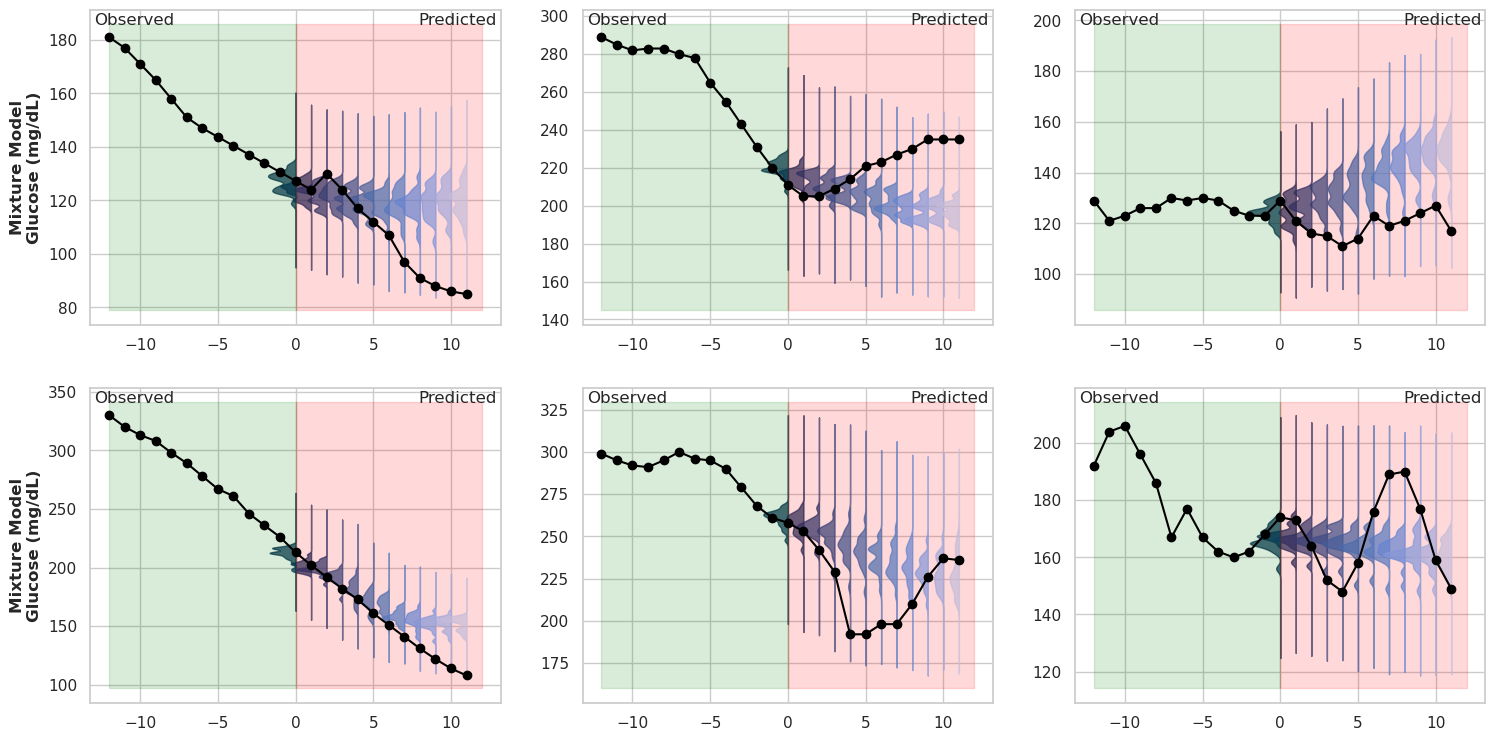

In [40]:
# plot
plot_samples = [100, 1100, 2500, 3000, 4000, 10000]
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

for ind in range(6):
        ax = axs[ind // 3, ind % 3]
        # if plot number == 0 or 3, add y-label
        if ind % 3 == 0:
                ax.set_ylabel('Mixture Model\nGlucose (mg/dL)')
        # select sample to plot
        ind = plot_samples[ind]
        for point in range(samples.shape[1]):
                kde = stats.gaussian_kde(samples[ind, point, :])
                maxi, mini = 1.2 * np.max(samples[ind, point, :]), 0.8 * np.min(samples[ind, point, :])
                y_grid = np.linspace(mini, maxi, 200)
                x = kde(y_grid)
                ax.fill_betweenx(y_grid, x1 = point, x2 = point - x * 15, 
                                alpha=0.7, 
                                edgecolor='black',
                                color=cmap(point / samples.shape[1]))
        # plot true value
        ax.plot(np.arange(-12, 12), 
                np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
                label='input', 
                color='black', 
                marker='o')
        # deliniate observed and predicted part
        abs_min, abs_max = ax.get_ylim()
        ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = 0, color='green', alpha=0.15)
        ax.fill_betweenx([abs_min, abs_max], x1 = 0, x2 = 12, color='red', alpha=0.15)
        ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes)
        ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes)
# save figure
plt.savefig('./presentation/plots/gluformer_prediction.pdf', bbox_inches='tight')